First, let us import all necessary libraries for this one

In [1]:
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import math
import time
from typing import List, Union, Dict
import scipy
import scipy.special

Same utility function for training

Also, in this one, we need to access a local storage. Please create a Google driver folder and enter their path below. It will ask you to grant permission to colab to access your google drive.

In [ ]:
#@title Mount Google drive (you need to grant colab to access your Google Drive)

from google.colab import drive

drive.mount('/content/drive')

srcpath = 'cuhk_courses/aims5702'  #@param {type:"string"}
srcpath = os.path.join('/content/drive/My Drive', srcpath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this one, we will build transformer, for both image classification and text processing. Note that GPU training is highly suggested, as it is much faster than CPU training.

First, let us still using the FashinMNIST dataset we used before.

# Problem A. Transformer on FashionMNIST

Again, let us load the dataset.

In [ ]:
#@title Load the training dataset

# Define transformations for the training and test sets

mean_train = 0.2860405743122101
std_train = 0.3530242443084717
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((mean_train,), (std_train,))
])

# The transformation applied to the testing is the same as training
transform_test = transforms.Compose([
    # For the ease of network design, we resize the image to 32x32[
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((mean_train,), (std_train,))
])

# Load the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.79MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.5MB/s]


## Transformer Model functions

Although, we can build a transformer on raw pixels, that is often slow in training. Instead, let us first downsample the input image into small size through a lightweight CNN.

Given an input image with resolution of `1(channel)x32(height)x32(width)`, design a one-layer network to convert that into `768(embedding_dim)x8(height)x8(width)`. It basically downsamples the input images by 4x. Then flatten it into a `768(embedding_dim)x64(num_patches)`

**Hint:**
* You can achieve this through a stirde=4 and kernel=4 convolution.
* You can use `torch.flatten(x, start_dim, end_dim)` to flatten 2D image into 1D sequence.
* You can use `torch.transpose` to switch two dimensions.

In [ ]:
#@title Problem A.1. Patching embedding class

def power_base_10000(x):
  """
  Computes the power of 10000.0 to the input tensor.

  Args:
    x: The input tensor.
  """
  return torch.exp(math.log(10000.0) * x)

class PatchEmbedding(nn.Module):
  """
  A module to convert an image into a sequence of patches and embed them.
  This is the first layer of a Vision Transformer.
  """
  def __init__(self, img_size, patch_size=4, in_channels=1, embedding_dim=768):
    """
    Args:
      img_size: The size of the image.
      patch_size: The size of the patch.
      in_channels: The number of channels in the image.
      embedding_dim: The dimension of the embedding.
    """
    super().__init__()
    #####################
    # Your code goes here
    #####################
    self.downsample = nn.Conv2d(
        in_channels = in_channels,
        out_channels = embedding_dim,
        kernel_size = patch_size,
        stride = patch_size)
    self.projection = None

  def forward(self, x):
    """
    Args:
      x: The input tensor with shape (Batch_Size, In_Channels, Height, Width).

    Returns:
      The output tensor with shape (Batch_Size, Embedding_Dim, Number_of_Patches).
    """
    #####################
    # Your code goes here
    #####################
    x = self.downsample(x)
    output = x.flatten(2)
    return output

Also, let us define the position encoding.

As discussed in the class, we can precompute a position embedding table:

`position_encoding_table[t, d]` is the `t` is the position of a token, and `d` is the feature dimension. Let us just use the definition in the class:

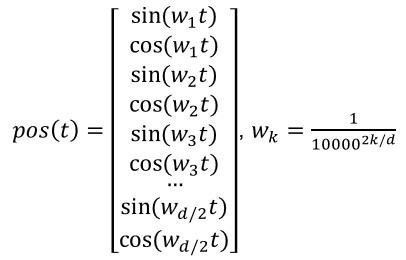

In [ ]:
#@title Problem A.2. PositionalEncoding

class PositionalEncoding(nn.Module):
  """
  Adds positional information to the patch embeddings.
  """
  def __init__(self, embedding_dim, max_seq_length=512):
    """
    Args:
      embedding_dim: The dimension of the embedding.
      max_seq_length: The maximum sequence length.
    """
    super().__init__()
    position_encoding_table = torch.zeros(max_seq_length, embedding_dim)
    # Create a position table.
    # position_encoding_table[i, :] should be length embedding_dim vector that
    # encodes the position i.
    #####################
    # Your code goes here
    #####################
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    w_k = power_base_10000(torch.arange(0, embedding_dim, 2)/embedding_dim)
    position_encoding_table[:, 0::2] = torch.sin(position * w_k)
    position_encoding_table[:, 1::2] = torch.cos(position * w_k)
    self.register_buffer('position_encoding_table', position_encoding_table)

  def forward(self, x):
    """
    Args:
      x: The input tensor with shape
          (Batch_Size, Sequence_Length, Embedding_Dim).

    Returns:
      The output tensor with shape (Batch_Size, Sequence_Length, Embedding_Dim).
    """
    _, seq_length, _ = x.shape
    return x + self.position_encoding_table[np.newaxis, :seq_length, :]

In [ ]:
#@title Problem A.3. ViTClassifier

# Transformer class
class ViTClassifier(nn.Module):
  """
  Complete Vision Transformer model for classification.
  """
  def __init__(self, img_size=32, patch_size=4, in_channels=1, num_classes=10,
               embedding_dim=768, num_heads=12, num_layers=6, dropout_rate=0.1):
    super().__init__()

    # First, let us create the patch embedding and positional encoding layers.
    self.patch_embedding = PatchEmbedding(
        img_size, patch_size, in_channels, embedding_dim
    )
    self.positional_encoding = PositionalEncoding(
        embedding_dim, (img_size // patch_size)**2
    )

    # Transformer Encoder layers
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embedding_dim,
        nhead=num_heads,
        dropout=dropout_rate,
        batch_first=True
    )
    self.transformer_encoder = nn.TransformerEncoder(
        encoder_layer, num_layers=num_layers
    )

    # This is the classification token CLS.
    self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

    # This is the MLP head for classification.
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(embedding_dim),
        nn.Linear(embedding_dim, num_classes)
    )

  def forward(self, x):
    """
    Args:
      x: The input tensor with shape (Batch_Size, In_Channels, Height, Width).

    Returns:
      The output tensor with shape (Batch_Size, Num_Classes).
    """
    # 1. Convert image to patches
    # (Batch_Size, In_Channels, Height, Width) ->
    #     (Batch_Size, H_p * W_p, Embedding_Dim)
    # H_p = Height // Patch_Size
    # W_p = Width // Patch_Size
    batch_size, _, _, _ = x.shape
    patches_embedded = self.patch_embedding(x).transpose(1, 2)

    # 2. Add positional information
    # (Batch_Size, H_p * W_p, Embedding_Dim) ->
    #     (Batch_Size, H_p * W_p, Embedding_Dim)
    patches_with_pos = self.positional_encoding(patches_embedded)

    # 3. Concatenate the learnable CLS token
    # After concatenating, the shape of the input tokens should be
    # (Batch_Size, H_p * W_p + 1, Embedding_Dim)
    #####################
    # Your code goes here
    #####################
    cls_token = self.cls_token.expand(batch_size, -1, -1)
    input_tokens_extended = torch.concatenate([cls_token, patches_with_pos],
                                              dim=1)

    # 4. Pass through the Transformer Encoder
    output_tokens = self.transformer_encoder(input_tokens_extended)

    # 5. Pass the CLS token through the MLP head for final classification
    #####################
    # Your code goes here
    #####################
    cls_token = output_tokens[:, 0, :]
    output = self.mlp_head(cls_token)

    return output

## Run training

Similar, let us use GPU this time.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


At last, uses the same training and testing loop.

At last, defines the dataloader, model, and optimizer.

In [ ]:
#@title Dataloader, model, and optimizer

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ViTClassifier()
model.to(device)
loss_fn = nn.CrossEntropyLoss()

epochs = 5   # Number of training epochs
optimizer = torch.optim.Adam(
  model.parameters(),    # All trainable parameters.
  lr=1e-4                # Learning rate
)

In [ ]:
#@title Utility functions for training

def train_one_epoch(
    dataloader: torch.utils.data.DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: str='cpu',
    loss_print_iter: int=100
  ):
  num_train_samples = len(dataloader.dataset)

  # Set the model to the training mod
  model.train()
  all_losses = []
  all_acc = []

  for batch_index, (image, label) in enumerate(dataloader):
    image, label = image.to(device), label.to(device)
    pred = model(image)
    loss = loss_fn(pred, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Calculate the loss
    all_losses.append(loss.item())
    acc = ((pred.argmax(1) == label).type(torch.float).sum().item() /
           image.shape[0])
    all_acc.append(acc)

    if batch_index % loss_print_iter == 0:
      loss, trained_samples = loss.item(), (batch_index + 1) * image.shape[0]
      print(f'loss: {loss:>7f} '
            f'[{trained_samples:>5d}/{num_train_samples:>5d}] ')

  return all_losses, all_acc

def test_all_samples(
    dataloader: torch.utils.data.DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    device: str='cpu'
) -> None:
  model.eval()  # Set the model to evaluation mode
  num_testing_samples = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  # Disable gradient calculation for inference
  with torch.no_grad():
    for image, label in dataloader:
      image, label = image.to(device), label.to(device)
      pred = model(image)
      test_loss += loss_fn(pred, label).item()
      correct += (pred.argmax(1) == label).type(torch.float).sum().item()

  test_loss /= num_batches
  acc = correct / num_testing_samples
  print(f'Test Error: \n Accuracy: {(100*acc):>0.1f}%, '
        f'Avg loss: {test_loss:>8f} \n')
  return test_loss, acc

At last, let us try to train it.

If your model is defined correctly, you should get 87-88% accuracy.

The training may take about 20-30min on T4

In [ ]:
#@title Training

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  start_time =time.time()
  _, _ = train_one_epoch(train_loader, model, loss_fn, optimizer, device=device)
  print(f'One epoch takes {time.time() - start_time}')
  _, _ = test_all_samples(test_loader, model, loss_fn, device=device)

test_all_samples(test_loader, model, loss_fn, device=device)

print("Training done!")

Epoch 1
-------------------------------
loss: 2.166112 [   32/60000] 
loss: 1.233310 [ 3232/60000] 
loss: 0.569527 [ 6432/60000] 
loss: 0.486533 [ 9632/60000] 
loss: 0.730586 [12832/60000] 
loss: 0.445954 [16032/60000] 
loss: 0.454513 [19232/60000] 
loss: 0.255805 [22432/60000] 
loss: 0.376292 [25632/60000] 
loss: 0.396322 [28832/60000] 
loss: 0.471332 [32032/60000] 
loss: 0.411718 [35232/60000] 
loss: 0.173303 [38432/60000] 
loss: 0.360600 [41632/60000] 
loss: 0.302020 [44832/60000] 
loss: 0.544018 [48032/60000] 
loss: 0.675721 [51232/60000] 
loss: 0.699524 [54432/60000] 
loss: 0.333553 [57632/60000] 
One epoch takes 284.2578411102295
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.480922 

Epoch 2
-------------------------------
loss: 0.541045 [   32/60000] 
loss: 0.161244 [ 3232/60000] 
loss: 0.267530 [ 6432/60000] 
loss: 0.310473 [ 9632/60000] 
loss: 0.483137 [12832/60000] 
loss: 0.106652 [16032/60000] 
loss: 0.409042 [19232/60000] 
loss: 0.278235 [22432/60000] 
loss: 0.626870 [25632/60

**Important**: Run the code below to save the model to your Google Drive, which will need it in the next question (so you do not need to wait for 30min to run it again).

In [ ]:
#@title Save model to the disk

MODEL_PATH = os.path.join(srcpath, 'trained_model_fashionmnist.pth')
torch.save(model.state_dict(), MODEL_PATH)

# Problem B. Save the trained model as ONNX and run inference

First, load the saved model

In [ ]:
model = ViTClassifier()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In next step, let us define the output path

In [ ]:
ONNX_PATH = os.path.join(srcpath, 'fashionmnist.onnx')

At last, we need to install ONNX.

In [ ]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
import onnx
import onnxruntime as ort

## Export the model to ONNX.

Given the trained model above, please

In [ ]:
# We first need to define a dummy input. The value does not matter. Just make
# sure the tensor shape is correct.
dummy_input = torch.zeros((1, 1, 32, 32))

# Define names for the input and output nodes
input_names = ['input']
output_names = ['output']

# Define axes that should have dynamic (variable) dimensions
# This allows the ONNX model to handle different batch sizes at runtime.
dynamic_axes = {
    'input': {0: 'batch_size'},   # Make the 0th dimension (batch size) dynamic
    'output': {0: 'batch_size'}  # Make the 0th dimension (batch size) dynamic
}

torch.onnx.export(
    model,              # The PyTorch model to export
    dummy_input,        # The sample input tensor
    ONNX_PATH,          # Where to save the model (file or file-like object)
    export_params=True, # Export trained weights with the model
    opset_version=17,   # The ONNX version to export to (choose one supported by your target platform)
    do_constant_folding=True, # Whether to execute constant folding for optimization
    input_names=input_names,  # Names of the model's inputs
    output_names=output_names, # Names of the model's outputs
    dynamic_axes=dynamic_axes # Specify dynamic dimensions
)

print(f"Model successfully exported to {ONNX_PATH}")

/tmp/ipython-input-2138492928.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Model successfully exported to /content/drive/My Drive/cuhk_courses/aims5702/fashionmnist.onnx


## Problem B.1. Reload the trained model, and test it

Let us first reload model and check if it is correct.

In [ ]:
onnx_model = onnx.load(ONNX_PATH)
# This raises an exception if the model is invalid
onnx.checker.check_model(onnx_model)
print("ONNX model is well-formed.")

ONNX model is well-formed.


In [ ]:
ort_session = ort.InferenceSession(ONNX_PATH)
ort_outputs = ort_session.run(
    ['output'], {'input': image.numpy()[np.newaxis, ...]})[0]
label = ort_outputs

Then, let us try to run it on testing cases. Please uses test on first 6 samples in testing.

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let us use the first 9 samples as testing cases.

To mimic how this may run in actual testing platform, let us remove all transformation.

Do not change the block below.

In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
)
testing_images = []
gt_labels = []
for i, (image, label) in enumerate(test_dataset):
  testing_images.append(np.asarray(image))
  gt_labels.append(class_names[label])
  if i == 8:
    break

At last, let us test our model on `testing_images` and compared with ground truth `gt_labels`. And visualize the result.

Here we provided code to generate 9 results in testing. And if you not super unlucky, you shall have at least half of them correct.

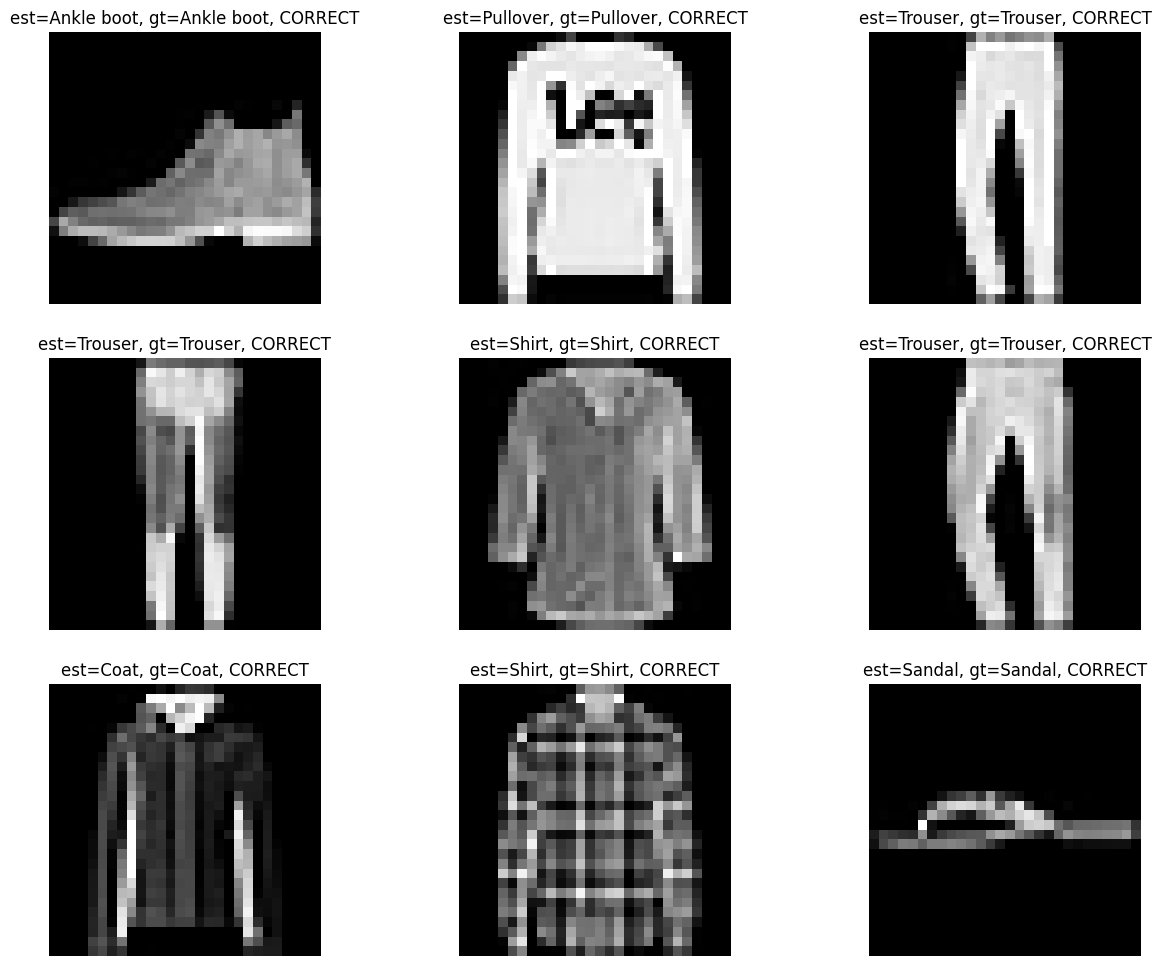

In [ ]:
#####################
# Your code goes here
#####################
ort_session = ort.InferenceSession(ONNX_PATH)

est_labels = []
eva_images = []
eva_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
for i, (image, label) in enumerate(eva_dataset):
    eva_images.append(np.asarray(image))
    if i == 8:
      break
for image in eva_images:
    ort_outputs = ort_session.run(['output'],
     {'input': image.astype(np.float32)[np.newaxis, ...]})[0]

    predicted_class_idx = np.argmax(ort_outputs)
    est_labels.append(class_names[predicted_class_idx])

plt.figure(figsize=(15, 12))
for i in range(len(testing_images)):
  correct = 'CORRECT' if est_labels[i] == gt_labels[i] else 'WRONG'
  plt.subplot(3, 3, i + 1)
  plt.imshow(testing_images[i], cmap='gray')
  plt.axis('off')
  plt.title(f'est={est_labels[i]}, gt={gt_labels[i]}, {correct}')

## Problem B.2 **Bonus**, run ONNX on web page

Please try to build either an HTML that can run the ONNX. This is time consuming and only try it you are comfortable.

If you do so, please submit:
* A screen record of how you run it.
* A zip file of webpage folder.

FYI, you can refer to some of these implementations:

https://github.com/mxkrn/onnxruntime-web-tutorial/tree/main

https://github.com/microsoft/onnxruntime-nextjs-template

https://onnxruntime.ai/docs/tutorials/web/classify-images-nextjs-github-template.html



# Problem C. Implement multi-head attention by yourself.

In the next step, let us try to implmenet a multihead attention by yourself, and match the implementaiton of pytorch.

Here we provided a reference implementation of softmax.

In [2]:
def softmax(x: np.ndarray) -> np.ndarray:
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

In pytorch, the there are two learnable matrices
* Input Projection Matrix (`in_proj_weight`), which consists of weight for K, Q, and V matrices. To reduce your burder, we already chop the input projection into wq, wk, and wq, each of which is `embedding_dim x embedding_dim`.
* Output Projection Matrix (`out_proj`), which is another `embedding_dim x embedding_dim`. It takes **combined** multi-head attention result into a single tensor (`batch_size x seq_length x embedding_dim`)
Also, to apply this linear matrice to the input feature, it should follow `out_feat[j] = sum_i (in_feat[i] * weight[j, i])`. In another word, the first dim of weight is output feature and second dim is the input feature.



Also, here is how pytorch deal with multi-head attention
* For multi-head attention, it will split the result after input project into `num_head` independent tensors, and combined them on channel dimension after attentions.
* For example, if the K tensor before splitting is `1 x 32 x 128`, where batch size is 1 and sequence length is 128. Then, to create 4 heads (`num_head=4`), it will split this matrix into 4 `1 x 32 x 32` K tensors. Q and V are splitted in the same way. After attention, it will obtained 4 `1 x 32 x 32` output tensors. They will be combined into a single `1 x 32 x 128` tensor.
* For your reference, we provided `_split_heads` and `_combine_heads` for these two operations, although you can implement your own one.

At last, to make your life easy, you only need to consider a simplfied cases:
* No bias in all calculation
* No need to consider attention mask

In [6]:
#@title CustomizedMultiHeadAttention

class CustomizedMultiHeadAttention(object):

  def __init__(self, embedding_dim: int, num_heads: int, dropout: float = 0.1):
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.dim_each_head = embedding_dim // num_heads

  def set_params(self,
    param_dict: Dict[str, torch.Tensor]
  ) -> None:
    """
    Set the parameters of the layer, like weight and bias of linear layer.

    Args:
      wq: The weight matrix for Q.
      wk: The weight matrix for K.
      V_linear: The weight matrix for V.
      wout: The weight matrix for the output.
    """
    self.wq = param_dict['wq']
    self.wk = param_dict['wk']
    self.wv = param_dict['wv']
    self.wout = param_dict['wout']

  def _split_heads(self, x: np.ndarray) -> np.ndarray:
    """
    Splits KQV matrix into multiple heads.

    Args:
      x: A tensor of shape (batch_size, sequence_length, embedding_dim)

    Returns:
      A tensor of shape (batch_size, num_heads, sequence_length, dim_each_head)
    """
    batch_size, seq_len, _ = x.shape
    x = x.reshape(batch_size, seq_len,
                  self.num_heads, self.dim_each_head).transpose(0, 2, 1, 3)
    return x

  def _combine_heads(self, x: np.ndarray) -> np.ndarray:
    """
    Combines multiple heads into a single matrix.

    Args:
      x: A tensor of shape
          (batch_size, num_heads, sequence_length, dim_each_head)

    Returns:
      A tensor of shape (batch_size, sequence_length, embedding_dim)
    """
    batch_size, _, seq_len, _ = x.shape
    x = x.transpose((0, 2, 1, 3))
    return x.reshape(batch_size, seq_len, self.embedding_dim)

  def forward(self, input_k: np.ndarray, input_v: np.ndarray, input_q: np.ndarray) -> np.ndarray:
    """
    Forward pass of the layer.

    Args:
      input_k: A tensor of shape (batch_size, kv_length, feature_dim)
      input_v: A tensor of shape (batch_size, kv_length, feature_dim)
      input_q: A tensor of shape (batch_size, q_length, feature_dim)

    Returns:
      The output of the layer, shape is (batch_size, sequence_length, embedding_dim).
    """
    #####################
    # Your code goes here
    #####################
    q_proj = np.matmul(input_q, self.wq.T)
    k_proj = np.matmul(input_k, self.wk.T)
    v_proj = np.matmul(input_v, self.wv.T)
    multi_k = self._split_heads(k_proj)
    multi_v = self._split_heads(v_proj)
    multi_q = self._split_heads(q_proj)

    attention_score = softmax(np.matmul(multi_q, multi_k.transpose(0, 1, 3, 2))/
                      np.sqrt(self.dim_each_head))
    multi_out = np.matmul(attention_score, multi_v)

    combine = self._combine_heads(multi_out)

    output = np.matmul(combine, self.wout.T)

    return output

At last, let us verify the correctness of your impelementation. Please do not change the following block.

In [4]:
#@title Verification function

def verify_output(
    actual: Union[np.ndarray, List[np.ndarray]],
    reference: Union[np.ndarray, List[np.ndarray]],
    name: Union[str, List[str]],
    atol: float = 1e-6,
    rtol: float = 1e-6
) -> None:
  """
  Verify if the actual output is close to the reference output.

  Args:
    actual: The actual output.
    reference: The reference output.
    atol: The absolute tolerance.
    rtol: The relative tolerance.
  """
  if isinstance(actual, np.ndarray):
    close = np.allclose(actual, reference, atol=atol, rtol=rtol)
    if not close:
      print(f"{name} is not close to the reference output.")
    else:
      print(f"{name} is close to the reference output.")
  elif isinstance(actual, List):
    close = all(verify_output(a, b, name[i], atol=atol, rtol=rtol)
                for i, (a, b) in enumerate(zip(actual, reference)))
  return close

def compare_with_actual_layer(
    official_multi_head_attention: nn.modules,
    customized_multi_head_attention: CustomizedMultiHeadAttention,
    input_k: np.ndarray,
    input_v: np.ndarray,
    input_q: np.ndarray,
    wq: np.ndarray,
    wk: np.ndarray,
    wv: np.ndarray,
    wout: np.ndarray,
    a_tol: float = 1e-6,
    r_tol: float = 1e-6,
) -> bool:
  """
  Compare forward of your customized layer with the official layer.

  Args:
    official_layer: The official layer.
    customized_layer: The customized layer.
    input_k: The input numpy array for K (batch_size, kv_length, feature_dim).
    input_v: The input numpy array for V (batch_size, kv_length, feature_dim).
    input_q: The input numpy array for Q (batch_size, q_length, feature_dim).
    wq: The input numpy array for WQ (feature_dim, feature_dim).
    wk: The input numpy array for WK (feature_dim, feature_dim).
    wv: The input numpy array for WV (feature_dim, feature_dim).
    wout: The input numpy array for WOUT (feature_dim, feature_dim).
    a_tol: The absolute tolerance.
    r_tol: The relative tolerance.

  Returns:
    True if the output of the customized layer is close to the output of
    the official layer, False otherwise.
  """
  success = True
  input_k_torch, input_v_torch, input_q_torch = (
      torch.tensor(input_k),
      torch.tensor(input_v),
      torch.tensor(input_q)
  )

  # Set parameters
  official_multi_head_attention.in_proj_weight.data.copy_(
    torch.tensor(np.concatenate([wq, wk, wv], axis=0))
  )
  official_multi_head_attention.out_proj.weight.data.copy_(
    torch.tensor(wout)
  )
  customized_multi_head_attention.set_params({
    'wq': wq,
    'wk': wk,
    'wv': wv,
    'wout': wout
  })

  # Run forward.
  output_customized_np = customized_multi_head_attention.forward(
    input_k, input_v, input_q
  )
  output_official_torch, _ = official_multi_head_attention(
      input_q_torch, input_k_torch, input_v_torch)
  output_official_np = output_official_torch.detach().numpy()

  # Check output
  success = verify_output(output_customized_np, output_official_np,
                          'Output', atol=a_tol, rtol=r_tol)
  if not success:
    return success

In [8]:
#@title Run verification

for batch_size, feature_dim, num_heads, sequence_length in [
    (1, 16, 4, 7),
    (1, 128, 8, 7),
    (1, 16, 4, 243),
    (8, 16, 4, 7),
]:
  print(f'=== Testing with batch_size = {batch_size} '
        f'feature_dim = {feature_dim} '
        f'num_heads = {num_heads} ===')
  def _apply_norm(x):
    with torch.no_grad():
      norm = torch.nn.LayerNorm(feature_dim)
      x_torch = torch.tensor(x)
      normed_torch = norm(x_torch)
    return normed_torch.numpy()
  # Mimic layered norm when generating input
  input_k = _apply_norm(np.random.randn(
      batch_size, sequence_length, feature_dim).astype(np.float32))
  input_v = _apply_norm(np.random.randn(
      batch_size, sequence_length, feature_dim).astype(np.float32))
  input_q = _apply_norm(np.random.randn(
      batch_size, sequence_length, feature_dim).astype(np.float32))
  wq = np.random.randn(feature_dim, feature_dim).astype(np.float32)
  wk = np.random.randn(feature_dim, feature_dim).astype(np.float32)
  wv = np.random.randn(feature_dim, feature_dim).astype(np.float32)
  wout = np.random.randn(feature_dim, feature_dim).astype(np.float32)

  customized_attention = CustomizedMultiHeadAttention(
      feature_dim, num_heads)
  torch_attention = nn.MultiheadAttention(
      feature_dim, num_heads, batch_first=True, bias=False)

  compare_with_actual_layer(
      torch_attention,
      customized_attention,
      input_k, input_v, input_q, wq, wk, wv, wout,
      a_tol=1e-4, r_tol=1e-4,
  )

=== Testing with batch_size = 1 feature_dim = 16 num_heads = 4 ===
Output is close to the reference output.
=== Testing with batch_size = 1 feature_dim = 128 num_heads = 8 ===
Output is close to the reference output.
=== Testing with batch_size = 1 feature_dim = 16 num_heads = 4 ===
Output is close to the reference output.
=== Testing with batch_size = 8 feature_dim = 16 num_heads = 4 ===
Output is close to the reference output.


# Problem D. Transformer on Text classification.

First, for this question, we need torchtext library.

Unfortunately, due to some version issues, you need to reinstall torch.

So please **start a fresh new session** and run the following.

In [ ]:
!yes | pip uninstall torchvision torchaudio torch
!yes | pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
!yes | pip install torchtext==0.18.0
!yes | pip install torchdata==0.9.0
!yes | pip install portalocker==2.8.2

Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/torchvision-0.23.0+cu126.dist-info/*
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libcudart.45e7f3ed.so.12
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libjpeg.bd6b9199.so.8
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libnvjpeg.e5f20359.so.12
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libpng16.0481ee11.so.16
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libsharpyuv.b609dd4c.so.0
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libwebp.58a855fe.so.7
    /usr/local/lib/python3.12/dist-packages/torchvision.libs/libz.622bbd06.so.1
    /usr/local/lib/python3.12/dist-packages/torchvision/*
Proceed (Y/n)?   Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Woul

This is an old version of code, so you will see some degradation warning. Just ignore it.

In [ ]:
import os
import re
import math
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
import torchtext.datasets as datasets
import torchtext.vocab as torchvocab

from typing import List, Tuple, Iterable
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.12/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

First, define some constant

In [ ]:
max_seq_length = 256  # Maximum token length
batch_size = 32
vocab_cap = 30000  # Size of vocabulatory

## Problem description

The IMDB dataset contains several movie comments, and one label, whether this comment is positive or negative. We will train a transformer to check to predict this label (positive or negative) from the input comment.

To achieve this, the main different from Problem A is how to encode text. Here we use a simple encoder, which basically does follows:

* **Raw input**, which will be a sentence, like `This is a terrible movie`
* **Chop into tokens**. Here we chop it into a single word (token) and convert to lower cases, like `this` `is` `a` `terrible` `movie`. This is done through a simple tokenizer (5 tokens).
* **Convert tokens to ID**. We further convert each token (letter) into a ID (a number), so that it can be process by the network. This is done through a simple vocabulary (dictionary).
* **Compute the embedding feature of ID**. Since a single scalar is hard to be process by the network, we further encode them into a vector, using `nn.Embedding`.

The chop_into_token and convert_token_to_Id steps are done in the dataset creation, and embedding feature calculation is done in the first step of the network.

## Problem D.1 Build dataset (just run it)

Let us first load the raw text data.

In [ ]:
raw_train_data = list(datasets.IMDB(split='train'))
raw_test_data = list(datasets.IMDB(split='test'))

print(f'Number of training data is {len(raw_train_data)}')
print(f'Number of testing data is {len(raw_test_data)}')

/usr/local/lib/python3.12/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


Number of training data is 25000
Number of testing data is 25000


And let us visualize how the data may look

In [ ]:
for i, name in [(1, 'negative'), (2, 'positive')]:
  examples = [x for x in raw_train_data if x[0] == i]
  print(f'==== These are {name} feedbacks ====')
  for example in examples[::100][:5]:
    print(example)

==== These are negative feedbacks ====
(1, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex an

First, let us define a simple tokenizer. Just chop the sentence into words and convert them to lower cases.

In [ ]:
#@title A simple tokenizer

def simple_tokenize(text: str) -> List[str]:
  """For generalization, we just convert all letters to lower cases."""
  return re.findall(r"[A-Za-z0-9']+", text.lower())

And let us try it.

In [ ]:
raw_str = 'This is a bad movie'
print(simple_tokenize(raw_str))

['this', 'is', 'a', 'bad', 'movie']


Here we also need to define some special tokens.
* PAD is used to pad the sentence when the input sentences is shorter than `max_seq_length`
* UNK is used when vocabulatory cannot encode a new token.
* CLS is the CLS token as Problem A.

In [ ]:
PAD, UNK, CLS = '<pad>', '<UNK>', '<cls>'

Then, we can calculate the vocabulary, which we will use it to convert each word into ID. Here we use function from torchtext.

In [ ]:
#@title Create vocabulary

def create_vocab(
    raw_data: List[Tuple[int, str]],
    vocab_cap: int = 30000
) -> torchvocab.Vocab:
  """
  Create a vocabulary from the raw training data.

  Args:
    raw_data: The raw training data.
    vocab_cap: The maximum number of tokens in the vocabulary.

  Returns:
    A vocabulary.
  """
  def _yield_tokens(examples: Iterable[Tuple[str, str]]):
    # torchtext IMDB: (label, text)
    for label, text in examples:
      yield simple_tokenize(text)
  simple_vocab = torchvocab.build_vocab_from_iterator(
      _yield_tokens(raw_data), specials=[PAD, UNK, CLS],
      max_tokens=vocab_cap)
  simple_vocab.set_default_index(simple_vocab[UNK])
  return simple_vocab

simple_vocab = create_vocab(raw_train_data)

Let us try it with the simple tokenizer. Note the last token is unknown, so vocab output UNK (ID=1).

In [ ]:
for word in [PAD, UNK, CLS]:
  print(f'special token `{word}` is encoded as {simple_vocab[word]}')

raw_str = 'This is a bad movie dafhancbahgdh'
for word in simple_tokenize(raw_str):
  print(f'word `{word}` is encoded as {simple_vocab[word]}')

special token `<pad>` is encoded as 0
special token `<UNK>` is encoded as 1
special token `<cls>` is encoded as 2
word `this` is encoded as 13
word `is` is encoded as 8
word `a` is encoded as 5
word `bad` is encoded as 77
word `movie` is encoded as 19
word `dafhancbahgdh` is encoded as 1


Then let us create a function that converts raw text into IDs, using the vocabulatary above.

In [ ]:
#@title Create dataset preprocessor.

class PadCollate:
  def __init__(self, max_len: int, pad_id: int, cls_id: int, vocab: any):
    self.max_len = max_len
    self.pad_id = pad_id
    self.cls_id = cls_id
    self.vocab = vocab

  def __call__(self, batch):
    """
    Args:
      batch: A list of tuples, each containing a list of tokens
            (tokenized movie comments) and a label (1 or 2).

    Returns:
      A tuple containing the input ids, the key padding mask, and the labels.
    """
    # batch: List[(tokens, label)]
    ids_list, labels, lengths = [], [], []
    for toks, label in batch:
      ids = [self.vocab[token] for token in toks][: self.max_len - 1]
      ids = [self.cls_id] + ids
      ids_list.append(ids)
      labels.append(label)
      lengths.append(len(ids))

    T = min(self.max_len, max(lengths))
    B = len(batch)

    input_ids = torch.full((B, T), self.pad_id, dtype=torch.long)
    for i, ids in enumerate(ids_list):
      cur = ids[:T]
      input_ids[i, :len(cur)] = torch.tensor(cur, dtype=torch.long)

    # key_padding_mask: True is for padded token
    # (will be ignored by the Transformer encoder)
    # Shape is [batch_size, sequence_length], bool
    key_padding_mask = (input_ids == self.pad_id)

    # Also, packed the labels
    labels = torch.tensor(labels, dtype=torch.long)

    return input_ids, key_padding_mask, labels

pad_collate = PadCollate(
    max_len=256,
    pad_id=simple_vocab[PAD],
    cls_id=simple_vocab[CLS],
    vocab=simple_vocab
)

In [ ]:
ids, key_mask, _ = pad_collate([(y, x) for x, y in raw_train_data[:100]])

print('The ID is a matrix with shape [sample_size x max_length]')
print('For example, for the first 100 samples, the size of ids is '
      f'{ids.shape[0]}x{ids.shape[1]}')

The ID is a matrix with shape [sample_size x max_length]
For example, for the first 100 samples, the size of ids is 100x256


Note that some sentences are short, which cannot reach the maximum token length. For those sentences, we use key_padding_mask, like this one:

In [ ]:
index = 59
sample_text = raw_train_data[index][1]
sample_label = raw_train_data[index][0]

print('=== This is the raw input text ===')
print(raw_train_data[index][1])
print(f'The length of this sentence is {len(sample_text)}, '
      f'which is smaller than the {max_seq_length}.')
print('\n=== And this is encoded results. ===')
print('Note that the last few tokens are 0, '
      'which shows these are padded token.')
print(ids[index, :])
print('\n=== This is masked out in the key masking. '
      'So we will not calculate them. ===')
print(key_mask[index, :])

=== This is the raw input text ===
Ned aKelly is such an important story to Australians but this movie is awful. It's an Australian story yet it seems like it was set in America. Also Ned was an Australian yet he has an Irish accent...it is the worst film I have seen in a long time
The length of this sentence is 247, which is smaller than the 256.

=== And this is encoded results. ===
Note that the last few tokens are 0, which shows these are padded token.
tensor([   2,    1,  796,  818,    1,    5,    1,  796, 1718, 1718, 4896,    1,
          12,  398,    1,  398, 1208, 1074, 1969,    1,    5, 2607,    1,   12,
        1696, 1562, 1452, 1367,  746,    5, 2607,  746,    1,  398,  746, 1452,
        1367, 4896,    1,  746, 1452,    1,    1, 1208,  398,  746, 1367,    5,
        1718,   12,    5, 2607,  398,    1,  496, 1208,  746,    1,  746, 1969,
          12,  398,    1, 1696, 1452, 1895,   12,  796,    1,   12,  398,    1,
           5, 1993, 1167, 1208, 1718,    1,    1,    1,  74

Finally, we can build the training dataset.

In [ ]:
#@title Finally create the dataset

class IMDBListDataset(Dataset):
  def __init__(self, examples: List[Tuple[str, str]]):
    self.data = []
    for raw_label, text in examples:
      label = 1 if raw_label == 2 else 0
      toks = simple_tokenize(text)
      self.data.append((toks, label))
  def __len__(self): return len(self.data)
  def __getitem__(self, idx): return self.data[idx]

train_loader = DataLoader(IMDBListDataset(raw_train_data), batch_size=batch_size,
                          shuffle=True, collate_fn=pad_collate, num_workers=2)
test_loader  = DataLoader(IMDBListDataset(raw_test_data), batch_size=batch_size,
                          shuffle=False, collate_fn=pad_collate, num_workers=2)

Visualize the first 2 samples in the `train_loader`. Note the loader output is different from previous Problem A and when running the training iteration, we need to change `train_one_epoch` function accordingly.

In [ ]:
for batch_index, (ids, key_masking, labels) in enumerate(test_loader):
  print(f'The shape of input_ids is {ids.shape}')
  print(f'The shape of mask is {key_masking.shape}')
  print(f'The shape of label is {labels.shape}')
  for i in range(2):
    print(f'==== Sample {i} ====')
    print('input_ids', ids[i, :])
    print('mask', key_masking[i, :])
    print('label is', labels[i])
  break

The shape of input_ids is torch.Size([32, 256])
The shape of mask is torch.Size([32, 256])
The shape of label is torch.Size([32])
==== Sample 0 ====
input_ids tensor([    2,    12,   118,   922,   926,     4,   243,  1689,     7,   275,
           55,    18,     5,   175,   922,   926,   101,   247,    25,   631,
            1,   468,  2522,     4,  7227,    12,   805,     7,    39,    13,
           12,    65,   121,    20,    11,     8,     7,    51,   247,   922,
          926,    16, 14951,   456,     8,     7,   322,  2142,     3,   203,
          708, 19190,   705,  3440,   728,  4582,  3959,  4424,    14,   151,
         1016,     3,   976,     4,  2147,    30,  2041,   104,   564,    29,
         3080,    18,     5,     1,     1,   958,   145,   251,    49,    25,
          147,     6,    24,    45,    49,    36,   103, 14951,   456,     8,
           51,   922,   926,   247,    44,    23,    44,   741,   818,     4,
         8773,   136,   177,   799,   237,    39,  1423,     

## Problem D.2. Model creation

Now, let us define the network. This is very similar to problem A. First, you can copy your implementation of PositionEncoding here.

In [ ]:
def power_base_10000(x):
  """
  Computes the power of 10000.0 to the input tensor.

  Args:
    x: The input tensor.
  """
  return torch.exp(math.log(10000.0) * x)

class PositionalEncoding(nn.Module):
  """
  Adds positional information to the patch embeddings.
  """
  def __init__(self, embedding_dim, max_seq_length=512):
    """
    Args:
      embedding_dim: The dimension of the embedding.
      max_seq_length: The maximum sequence length.
    """
    super().__init__()
    position_encoding_table = torch.zeros(max_seq_length, embedding_dim)
    # Create a position table.
    # position_encoding_table[i, :] should be length embedding_dim vector that
    # encodes the position i.
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    w_k = power_base_10000(torch.arange(0, embedding_dim, 2)/embedding_dim)
    position_encoding_table[:, 0::2] = torch.sin(position * w_k)
    position_encoding_table[:, 1::2] = torch.cos(position * w_k)
    self.register_buffer('position_encoding_table', position_encoding_table)

  def forward(self, x):
    """
    Args:
      x: The input tensor with shape
          (Batch_Size, Sequence_Length, Embedding_Dim).

    Returns:
      The output tensor with shape (Batch_Size, Sequence_Length, Embedding_Dim).
    """
    _, seq_length, _ = x.shape
    return x + self.position_encoding_table[np.newaxis, :seq_length, :]

At last, create the Transformer.

Hints:
* Check Problem A for how to define the network
* To apply key_padding_masking in attention, you can call it like: `output_tokens = transformer_encoder(input_tokens, src_key_padding_mask=key_padding_mask)`
* Here is one suggested setups: use 6 layers of trnasformer encoder layer, 4 multi heads, dropout = 0.1, and batch_first = True. (and you can definitely find a better one as you would prefer)

In [ ]:
class TextTransformerClassifier(nn.Module):
  def __init__(
    self,
    vocab_size: int,
    num_classes: int=2,
    embedding_dim: int=256,
    max_seq_length: int=256,
    pad_id: int = 0,
  ):
    super().__init__()

    # Since the input is only scalar, we use embedding layer to convert a scalar to an embeddings.
    # This is similar to the position embedding.
    # The input to this layer is [batch_size, sequence_length],
    # and the output is [batch_size, sequence_length, embedding_dim].
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_id)

    # Define the positional encoding layer.
    self.positional_encoding = PositionalEncoding(
        embedding_dim, max_seq_length=max_seq_length)

    #####################
    # Your code goes here
    #####################
    encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=4,
            dim_feedforward=4 * embedding_dim,
            dropout=0.1,
            batch_first=True  # Input shape: (batch, seq, features)
    )
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

    # Classification head
    self.classifier = nn.Linear(embedding_dim, num_classes)

  def forward(self, input_ids: torch.Tensor, key_padding_mask: torch.Tensor):
    """
    Forward pass of the encoder classifier.

    Args:
      input_ids: [batch_size, sequence_length],
      key_padding_mask: [batch_size, sequence_length] (True mean padded token,
          will be ignored by the Transformer encoder)

    Returns:
      The output tensor with shape [batch_size, num_classes].
    """
    # 1. Convert the input ids to embeddings
    # The input to this layer is [batch_size, sequence_length],
    # and the output is [batch_size, sequence_length, embedding_dim].
    seq_embedded = self.embed(input_ids)

    # Do the rest of transformer:
    # 2. Add positional information
    # 3. Transformer
    # 4. MLP head to CLS token
    #
    # Note:
    #   1. Unlike the previous ViT, here we already attach CLS
    #      token to the data preparation. So we don't need to
    #      concatenate the CLS token here.
    #   2. When calling the transformer encoder, src_key_padding_mask
    #      is used to mask the padding tokens in the input.
    #####################
    # Your code goes here
    #####################
    seq_embedded = self.positional_encoding(seq_embedded)

    encoded = self.transformer_encoder(
            seq_embedded,
            src_key_padding_mask=key_padding_mask
    )  # (batch, seq_len, embedding_dim)

    # Extract CLS token (first token) and classify
    cls_token = encoded[:, 0, :]
    output = self.classifier(cls_token)
    return output

## Problem D.3. Training

Similar, let us use GPU this time.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Write your training and evaluation code.

If your model is defined correctly, you should get at least 81% accuracy.

The training should be less than 30min on T4.

Note:
* Your code should print the testing accuracy on the testing set at the very end.

Hint:
* You can still use nn.CrossEntropyLoss()
* vocab_size should be `vocab_cap`
* You can refer to the `train_one_epoch` and `test_all_sample` above, but note that the input now has both `ids` and `key_masking`, and you need pass them both to the model.

In [ ]:
#####################
# Your code goes here
#####################
import numpy as np

def train_one_epoch(
    dataloader: torch.utils.data.DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: str='cpu',
    loss_print_iter: int=100
  ):
  num_train_samples = len(dataloader.dataset)

  # Set the model to the training mod
  model.train()
  all_losses = []
  all_acc = []

  for batch_index, (ids, key_masking, label) in enumerate(dataloader):
    ids = ids.to(device)
    key_masking = key_masking.to(device)
    label = label.to(device)
    pred = model(ids, key_masking)
    loss = loss_fn(pred, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Calculate the loss
    all_losses.append(loss.item())
    acc = ((pred.argmax(1) == label).type(torch.float).sum().item() /
           ids.shape[0])
    all_acc.append(acc)

    if batch_index % loss_print_iter == 0:
      loss, trained_samples = loss.item(), (batch_index + 1) * ids.shape[0]
      print(f'loss: {loss:>7f} '
            f'[{trained_samples:>5d}/{num_train_samples:>5d}] ')

  return all_losses, all_acc

def test_all_samples(
    dataloader: torch.utils.data.DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    device: str='cpu'
) -> None:
  model.eval()  # Set the model to evaluation mode
  num_testing_samples = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  # Disable gradient calculation for inference
  with torch.no_grad():
    for ids, key_masking, label in dataloader:
      ids, key_masking = ids.to(device), key_masking.to(device)
      label = label.to(device)
      pred = model(ids, key_masking)
      test_loss += loss_fn(pred, label).item()
      correct += (pred.argmax(1) == label).type(torch.float).sum().item()

  test_loss /= num_batches
  acc = correct / num_testing_samples
  print(f'Test Error: \n Accuracy: {(100*acc):>0.1f}%, '
        f'Avg loss: {test_loss:>8f} \n')
  return test_loss, acc


model = TextTransformerClassifier(vocab_size=vocab_cap)
model.to(device)
loss_fn = nn.CrossEntropyLoss()

epochs = 5   # Number of training epochs
optimizer = torch.optim.Adam(
  model.parameters(),    # All trainable parameters.
  lr=1e-4                # Learning rate
)

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  start_time =time.time()
  _, _ = train_one_epoch(train_loader, model, loss_fn, optimizer, device=device)
  print(f'One epoch takes {time.time() - start_time}')
  _, _ = test_all_samples(test_loader, model, loss_fn, device=device)

test_all_samples(test_loader, model, loss_fn, device=device)

print("Training done!")

Epoch 1
-------------------------------
loss: 0.714975 [   32/25000] 
loss: 0.735282 [ 3232/25000] 
loss: 0.627558 [ 6432/25000] 
loss: 0.682381 [ 9632/25000] 
loss: 0.560042 [12832/25000] 
loss: 0.428585 [16032/25000] 
loss: 0.489282 [19232/25000] 
loss: 0.719158 [22432/25000] 
One epoch takes 98.43339204788208


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Test Error: 
 Accuracy: 71.9%, Avg loss: 0.529089 

Epoch 2
-------------------------------
loss: 0.423075 [   32/25000] 
loss: 0.721571 [ 3232/25000] 
loss: 0.504981 [ 6432/25000] 
loss: 0.384265 [ 9632/25000] 
loss: 0.326023 [12832/25000] 
loss: 0.599656 [16032/25000] 
loss: 0.297390 [19232/25000] 
loss: 0.411415 [22432/25000] 
One epoch takes 98.96257376670837
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.389574 

Epoch 3
-------------------------------
loss: 0.301252 [   32/25000] 
loss: 0.194774 [ 3232/25000] 
loss: 0.392025 [ 6432/25000] 
loss: 0.302181 [ 9632/25000] 
loss: 0.292153 [12832/25000] 
loss: 0.497486 [16032/25000] 
loss: 0.271043 [19232/25000] 
loss: 0.318838 [22432/25000] 
One epoch takes 98.7974123954773
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.381251 

Epoch 4
-------------------------------
loss: 0.292259 [   32/25000] 
loss: 0.403503 [ 3232/25000] 
loss: 0.236165 [ 6432/25000] 
loss: 0.433466 [ 9632/25000] 
loss: 0.272281 [12832/25000] 
loss: 0.234620 [16032/25000